##  Covid Image Classification Using ResNet and Inference
COVID-19 detection models utilizing CT images involve the application of machine learning algorithms to analyze chest X-ray images, aiming to identify patterns and features associated with COVID-19 infections. The provided [dataset](https://www.kaggle.com/datasets/plameneduardo/a-covid-multiclass-dataset-of-ct-scans/) comprises 4173 CT scan images of the lungs (Chest CT Scan) with three different classes, including Covid, Healthy, and Others. Our focus for this assignment is solely on the first two classes.*italicized text*

### Download the Dataset

You can download the dataset of this relevant exercise using the code snippet below. Just note that you need to create an account in Kaggle first and then follow the steps below to receive your `kaggle.json` file and then upload it below:
1. Go to your Kaggle account, Scroll to the API section, and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download the `kaggle.json` file on your machine.

If you need more details to read, you can refer to this [link](https://www.kaggle.com/discussions/general/156610).


In [1]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download plameneduardo/a-covid-multiclass-dataset-of-ct-scans/

 98% 399M/405M [00:04<00:00, 71.5MB/s]
100% 405M/405M [00:04<00:00, 103MB/s] 


In [ ]:
!unzip ./a-covid-multiclass-dataset-of-ct-scans.zip

### Preprocessing

* The existing data structure consists of patient-wise subfolders. Thus, the initial step involves copying all images into the Covid, Healthy, and Other folders while eliminating any subfolders.

* Count the data in each class to determine if there is an imbalance issue or not.

In [6]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import cv2
import numpy as np
from sklearn import utils
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD
import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

 Creating ./data with its subfolders, splitting the files, and saving each file to its respective directory.

In [7]:
!mkdir ./data
!mkdir ./data/train
!mkdir ./data/test
!mkdir ./data/train/covid
!mkdir ./data/train/healthy
!mkdir ./data/test/covid
!mkdir ./data/test/healthy

In [8]:
def copyfiles(source, dest):
    file_names = []
    for foldername, subfolders, filenames in os.walk(source):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            file_names.append(file_path)

    train_files, test_files = train_test_split(file_names, test_size=0.2, random_state=42)
    for file_path in train_files:
        shutil.copy(file_path, os.path.join('./data/train' + dest, os.path.basename(file_path)))
    for file_path in test_files:
        shutil.copy(file_path, os.path.join('./data/test' + dest, os.path.basename(file_path)))

copyfiles('./New_Data_CoV2/Covid', '/covid')
copyfiles('./New_Data_CoV2/Healthy', '/healthy')

In [9]:
def count_files(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

print('The total number of files in trainset:',  count_files('./data/train/'))
print('The total number of files in testset:',  count_files('./data/test/'))

The total number of files in trainset: 2067
The total number of files in testset: 529


Visualize the dataset and plot some randomly selected sample images from the data.

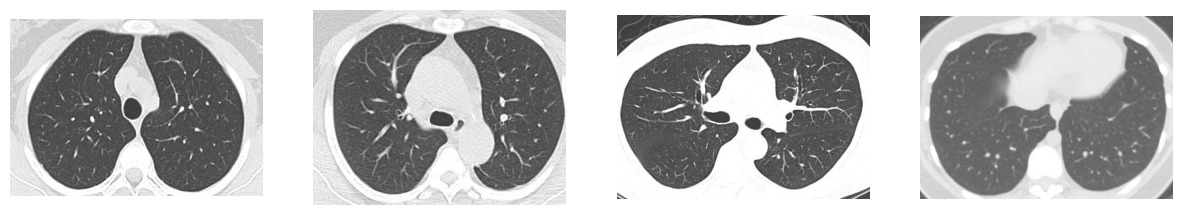

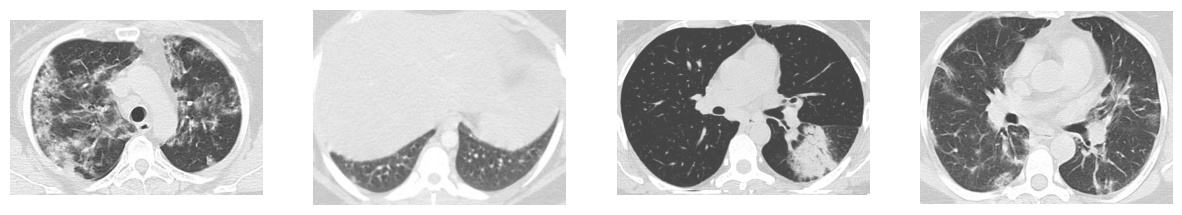

In [10]:
def plot_images_in_row(folder_path, num_images=4):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(image_files, min(num_images, len(image_files)))
    plt.figure(figsize=(15, 3))

    for i, image_file in enumerate(selected_images, start=1):
        plt.subplot(1, num_images, i)
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

covid_folder = './data/train/covid'
healthy_folder = './data/train/healthy'

plot_images_in_row(healthy_folder)
plot_images_in_row(covid_folder)

Create data loaders and apply preprocessing techniques, as well as augmentation and transformation methods, to enhance the model's performance. Also, split the data into train and test sets.

In [11]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

batch_size = 16

covid_train = os.listdir('./data/train/covid')
healthy_train = os.listdir('./data/train/healthy')

train_dataset = datasets.ImageFolder(root='./data/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='./data/test', transform=transform_test)

class_counts = [covid_train, healthy_train]
total_samples = sum(map(len, class_counts))
class_freq = [len(class_sample) / total_samples for class_sample in class_counts]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### ResNet

* Define your model here. You don't need to code it from scratch, and you can also utilize transfer learning if you believe it would enhance your model's performance.

* If a class imbalance problem exists, recommend a solution and implement it.

In [12]:
resnet_model = models.resnet18(pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_features, 2)
resnet_model = resnet_model.to(device)

class_weights = torch.FloatTensor([1.0 / freq for freq in class_freq]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.9MB/s]


In [13]:
def fit_model(epochs, model, criterion, optimizer, Train, Test):

    train_acc, train_loss = [], []
    test_acc, test_loss = [], []

    for epoch in range(epochs):
        epoch_acc, epoch_loss = 0, 0
        model = model.train()

        with tqdm.tqdm(enumerate(Train), total=len(Train)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                optimizer.zero_grad()
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)
                epoch_acc += (pred.t() == labels).sum().item()

        train_loss.append(epoch_loss/(i+1))
        train_acc.append(epoch_acc/len(Train.dataset))

        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Train.dataset)))

        epoch_acc, epoch_loss = 0, 0
        model.eval()

        with tqdm.tqdm(enumerate(Test), total=len(Test)) as pbar:
            for i, (images, labels) in pbar:
                images = images.to(device)
                labels = labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                epoch_loss += loss.detach().item()
                _, pred = output.data.topk(1, dim=1)

                epoch_acc += (pred.t() == labels).sum().item()

        test_loss.append(epoch_loss/(i+1))
        test_acc.append(epoch_acc/len(Test.dataset))

        print('Epoch: %d | Loss: %.4f | Test Accuracy: %.4f' \
          %(epoch, epoch_loss/(i+1), epoch_acc/len(Test.dataset)))

    return train_loss, train_acc, test_loss, test_acc


In [14]:
epochs = 40
train_loss , train_acc, test_loss, test_acc = fit_model(epochs, resnet_model,
                                                        criterion, optimizer,
                                                        train_loader, test_loader)

100%|██████████| 65/65 [00:16<00:00,  3.83it/s]

Epoch: 0 | Loss: 0.2604 | Train Accuracy: 0.8775



100%|██████████| 17/17 [00:02<00:00,  6.98it/s]

Epoch: 0 | Loss: 0.3649 | Test Accuracy: 0.8261



100%|██████████| 65/65 [00:11<00:00,  5.53it/s]

Epoch: 1 | Loss: 0.0794 | Train Accuracy: 0.9700



100%|██████████| 17/17 [00:02<00:00,  7.12it/s]

Epoch: 1 | Loss: 0.2003 | Test Accuracy: 0.9414



100%|██████████| 65/65 [00:11<00:00,  5.43it/s]

Epoch: 2 | Loss: 0.0662 | Train Accuracy: 0.9792



100%|██████████| 17/17 [00:02<00:00,  7.09it/s]

Epoch: 2 | Loss: 0.0977 | Test Accuracy: 0.9603



100%|██████████| 65/65 [00:11<00:00,  5.43it/s]

Epoch: 3 | Loss: 0.0389 | Train Accuracy: 0.9879



100%|██████████| 17/17 [00:02<00:00,  6.86it/s]

Epoch: 3 | Loss: 0.1075 | Test Accuracy: 0.9584



100%|██████████| 65/65 [00:12<00:00,  5.14it/s]

Epoch: 4 | Loss: 0.0178 | Train Accuracy: 0.9952



100%|██████████| 17/17 [00:03<00:00,  4.40it/s]

Epoch: 4 | Loss: 0.0436 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:10<00:00,  6.18it/s]

Epoch: 5 | Loss: 0.0322 | Train Accuracy: 0.9913



100%|██████████| 17/17 [00:03<00:00,  4.67it/s]

Epoch: 5 | Loss: 0.1006 | Test Accuracy: 0.9603



100%|██████████| 65/65 [00:11<00:00,  5.64it/s]

Epoch: 6 | Loss: 0.0226 | Train Accuracy: 0.9932



100%|██████████| 17/17 [00:03<00:00,  5.58it/s]

Epoch: 6 | Loss: 0.0358 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:11<00:00,  5.76it/s]

Epoch: 7 | Loss: 0.0063 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  6.03it/s]

Epoch: 7 | Loss: 0.0428 | Test Accuracy: 0.9830



100%|██████████| 65/65 [00:11<00:00,  5.64it/s]

Epoch: 8 | Loss: 0.0046 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:02<00:00,  6.41it/s]

Epoch: 8 | Loss: 0.0514 | Test Accuracy: 0.9773



100%|██████████| 65/65 [00:11<00:00,  5.57it/s]

Epoch: 9 | Loss: 0.0270 | Train Accuracy: 0.9893



100%|██████████| 17/17 [00:02<00:00,  7.04it/s]

Epoch: 9 | Loss: 0.0785 | Test Accuracy: 0.9698



100%|██████████| 65/65 [00:11<00:00,  5.43it/s]

Epoch: 10 | Loss: 0.0149 | Train Accuracy: 0.9952



100%|██████████| 17/17 [00:02<00:00,  6.89it/s]

Epoch: 10 | Loss: 0.0757 | Test Accuracy: 0.9735



100%|██████████| 65/65 [00:11<00:00,  5.48it/s]

Epoch: 11 | Loss: 0.0363 | Train Accuracy: 0.9927



100%|██████████| 17/17 [00:02<00:00,  7.14it/s]

Epoch: 11 | Loss: 0.0436 | Test Accuracy: 0.9849



100%|██████████| 65/65 [00:12<00:00,  5.40it/s]

Epoch: 12 | Loss: 0.0052 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:02<00:00,  7.16it/s]

Epoch: 12 | Loss: 0.0176 | Test Accuracy: 0.9943



100%|██████████| 65/65 [00:11<00:00,  5.49it/s]

Epoch: 13 | Loss: 0.0027 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:02<00:00,  7.19it/s]

Epoch: 13 | Loss: 0.0285 | Test Accuracy: 0.9868



100%|██████████| 65/65 [00:12<00:00,  5.40it/s]

Epoch: 14 | Loss: 0.0063 | Train Accuracy: 0.9976



100%|██████████| 17/17 [00:02<00:00,  6.79it/s]

Epoch: 14 | Loss: 0.1953 | Test Accuracy: 0.9490



100%|██████████| 65/65 [00:12<00:00,  5.39it/s]

Epoch: 15 | Loss: 0.0337 | Train Accuracy: 0.9898



100%|██████████| 17/17 [00:02<00:00,  7.05it/s]

Epoch: 15 | Loss: 0.0340 | Test Accuracy: 0.9905



100%|██████████| 65/65 [00:12<00:00,  5.29it/s]

Epoch: 16 | Loss: 0.0063 | Train Accuracy: 0.9985



100%|██████████| 17/17 [00:02<00:00,  6.74it/s]

Epoch: 16 | Loss: 0.0406 | Test Accuracy: 0.9830



100%|██████████| 65/65 [00:11<00:00,  5.42it/s]

Epoch: 17 | Loss: 0.0096 | Train Accuracy: 0.9976



100%|██████████| 17/17 [00:02<00:00,  7.11it/s]

Epoch: 17 | Loss: 0.1475 | Test Accuracy: 0.9584



100%|██████████| 65/65 [00:14<00:00,  4.62it/s]

Epoch: 18 | Loss: 0.0320 | Train Accuracy: 0.9889



100%|██████████| 17/17 [00:03<00:00,  4.33it/s]

Epoch: 18 | Loss: 0.0357 | Test Accuracy: 0.9849



100%|██████████| 65/65 [00:13<00:00,  4.92it/s]

Epoch: 19 | Loss: 0.0390 | Train Accuracy: 0.9918



100%|██████████| 17/17 [00:03<00:00,  5.02it/s]

Epoch: 19 | Loss: 0.1359 | Test Accuracy: 0.9546



100%|██████████| 65/65 [00:11<00:00,  5.70it/s]

Epoch: 20 | Loss: 0.0124 | Train Accuracy: 0.9952



100%|██████████| 17/17 [00:04<00:00,  4.19it/s]

Epoch: 20 | Loss: 0.0588 | Test Accuracy: 0.9792



100%|██████████| 65/65 [00:10<00:00,  6.14it/s]

Epoch: 21 | Loss: 0.0049 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:03<00:00,  4.74it/s]

Epoch: 21 | Loss: 0.0234 | Test Accuracy: 0.9887



100%|██████████| 65/65 [00:11<00:00,  5.81it/s]

Epoch: 22 | Loss: 0.0011 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:03<00:00,  5.30it/s]

Epoch: 22 | Loss: 0.0228 | Test Accuracy: 0.9905



100%|██████████| 65/65 [00:11<00:00,  5.54it/s]

Epoch: 23 | Loss: 0.0008 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.16it/s]

Epoch: 23 | Loss: 0.0217 | Test Accuracy: 0.9905



100%|██████████| 65/65 [00:12<00:00,  5.36it/s]

Epoch: 24 | Loss: 0.0009 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.87it/s]

Epoch: 24 | Loss: 0.0280 | Test Accuracy: 0.9905



100%|██████████| 65/65 [00:12<00:00,  5.08it/s]

Epoch: 25 | Loss: 0.0011 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.61it/s]

Epoch: 25 | Loss: 0.0218 | Test Accuracy: 0.9905



100%|██████████| 65/65 [00:12<00:00,  5.27it/s]

Epoch: 26 | Loss: 0.0006 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:03<00:00,  5.31it/s]

Epoch: 26 | Loss: 0.0194 | Test Accuracy: 0.9905



100%|██████████| 65/65 [00:12<00:00,  5.39it/s]

Epoch: 27 | Loss: 0.0020 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:02<00:00,  7.06it/s]

Epoch: 27 | Loss: 0.0166 | Test Accuracy: 0.9962



100%|██████████| 65/65 [00:12<00:00,  5.29it/s]

Epoch: 28 | Loss: 0.0006 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  7.01it/s]

Epoch: 28 | Loss: 0.0139 | Test Accuracy: 0.9962



100%|██████████| 65/65 [00:12<00:00,  5.39it/s]

Epoch: 29 | Loss: 0.0008 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.87it/s]

Epoch: 29 | Loss: 0.0158 | Test Accuracy: 0.9962



100%|██████████| 65/65 [00:12<00:00,  5.31it/s]

Epoch: 30 | Loss: 0.0008 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.99it/s]

Epoch: 30 | Loss: 0.0108 | Test Accuracy: 0.9962



100%|██████████| 65/65 [00:12<00:00,  5.36it/s]

Epoch: 31 | Loss: 0.0013 | Train Accuracy: 0.9995



100%|██████████| 17/17 [00:02<00:00,  7.19it/s]

Epoch: 31 | Loss: 0.0234 | Test Accuracy: 0.9905



100%|██████████| 65/65 [00:12<00:00,  5.42it/s]

Epoch: 32 | Loss: 0.0004 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  6.89it/s]

Epoch: 32 | Loss: 0.0196 | Test Accuracy: 0.9962



100%|██████████| 65/65 [00:12<00:00,  5.38it/s]

Epoch: 33 | Loss: 0.0005 | Train Accuracy: 1.0000



100%|██████████| 17/17 [00:02<00:00,  7.17it/s]

Epoch: 33 | Loss: 0.0201 | Test Accuracy: 0.9943



100%|██████████| 65/65 [00:11<00:00,  5.46it/s]

Epoch: 34 | Loss: 0.0037 | Train Accuracy: 0.9985



100%|██████████| 17/17 [00:02<00:00,  6.71it/s]

Epoch: 34 | Loss: 0.0777 | Test Accuracy: 0.9698



100%|██████████| 65/65 [00:11<00:00,  5.47it/s]

Epoch: 35 | Loss: 0.0100 | Train Accuracy: 0.9971



100%|██████████| 17/17 [00:02<00:00,  6.01it/s]

Epoch: 35 | Loss: 0.1334 | Test Accuracy: 0.9509



100%|██████████| 65/65 [00:11<00:00,  5.70it/s]

Epoch: 36 | Loss: 0.0065 | Train Accuracy: 0.9990



100%|██████████| 17/17 [00:03<00:00,  4.83it/s]

Epoch: 36 | Loss: 0.0536 | Test Accuracy: 0.9811



100%|██████████| 65/65 [00:10<00:00,  5.91it/s]

Epoch: 37 | Loss: 0.0187 | Train Accuracy: 0.9937



100%|██████████| 17/17 [00:03<00:00,  4.70it/s]

Epoch: 37 | Loss: 0.0451 | Test Accuracy: 0.9849



100%|██████████| 65/65 [00:10<00:00,  6.04it/s]

Epoch: 38 | Loss: 0.0054 | Train Accuracy: 0.9981



100%|██████████| 17/17 [00:04<00:00,  4.22it/s]

Epoch: 38 | Loss: 0.0563 | Test Accuracy: 0.9792



100%|██████████| 65/65 [00:10<00:00,  6.17it/s]

Epoch: 39 | Loss: 0.0078 | Train Accuracy: 0.9976



100%|██████████| 17/17 [00:03<00:00,  4.68it/s]

Epoch: 39 | Loss: 0.1172 | Test Accuracy: 0.9698


Plot Accuracy and Loss plots for both training and validation parts.

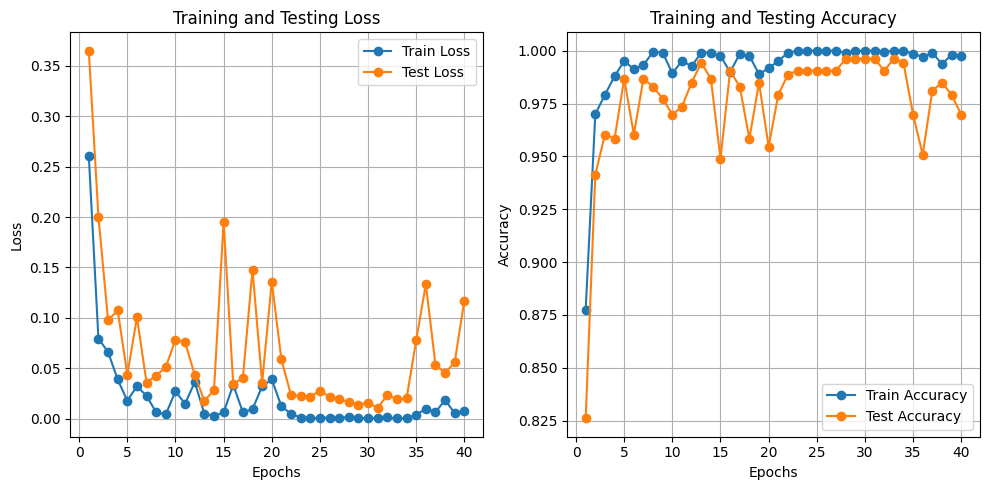

In [15]:
epochs = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='o')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, test_acc, label='Test Accuracy', marker='o')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Interpretability
Here, we aim to select an interpretability algorithm that aids in comprehending the model's decision-making process, debugging, and explaining predictions to non-technical stakeholders. Let's opt for the [Grad-CAM](https://arxiv.org/abs/1610.02391) technique. Grad-CAM, short for Gradient-weighted Class Activation Mapping, highlights important regions in an image that contribute to the model's prediction. This is achieved by computing the gradients of the target class with respect to the final convolutional layer. First, explain about this method and how it works, then implement this technique and visualize the resulting heatmaps.

[GradCam github](https://github.com/jacobgil/pytorch-grad-cam)

**Your Answer (10 points)**:

The Grad-CAM technique works as follows:

 • Given an input image and a target class, forward-propagate the image through the CNN model and identify the final convolutional layer.

 • Compute the gradients of the target class score with respect to the feature maps of the final convolutional layer.

 • Pool the gradients over all the spatial locations (by global average pooling) to obtain the neuron importance weights for each feature map.

 • Perform a weighted combination of the feature maps using the neuron importance weights to obtain a coarse Grad-CAM localization map.

 • Apply a ReLU function to the Grad-CAM map to retain only the positive activations that have a positive influence on the target class.

 • Resize and overlay the Grad-CAM map on the input image to obtain the final visualization.


**GradCam usage (60 points)**:

In [16]:
'''
  Initially, it is crucial to ensure that the model is in Evaluation mode.
  Failing to do so during result verification could inadvertently alter the
  model's weights, leading to inaccurate and unreliable results.
'''
resnet_model.eval()
device = "cpu"
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Within this section, leverage GradCam to create a function that generates a plot for a given image address. The function should display the image and overlay a heatmap (which was generated by GradCam) on it in a separate plot. **For this, use the 4th layer of your trained Resent**.

In [151]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def get_features_and_grads(model, layer_name):
    features = []
    grads = []

    def save_features(module, input, output):
        features.append(output)

    def save_grads(module, grad_input, grad_output):
        grads.append(grad_output[0])

    layer = dict([*model.named_modules()])[layer_name]

    features_hook = layer.register_forward_hook(save_features)
    grads_hook = layer.register_backward_hook(save_grads)

    return features_hook, grads_hook, features, grads

def get_gradcam(features, grads):
    feature_map = features[-1][0]
    grad = grads[-1][0]

    weights = grad.mean(dim=(1, 2), keepdim=True)

    weighted_feature_map = (feature_map * weights).sum(dim=0)

    relu = torch.nn.ReLU()
    cam = relu(weighted_feature_map)

    cam = cam.detach().cpu().numpy()
    cam = cam / cam.max()

    # Resize the heatmap to match the original image size
    cam = cv2.resize(cam, (224, 224))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)


    return heatmap

def plot_GradCam(image_path):
    image = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    features_hook, grads_hook, features, grads = get_features_and_grads(resnet_model, "layer4")

    output = resnet_model(image_tensor)
    target = output.argmax(dim=1)
    output[0][target].backward()


    bgr_image = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    bgr_image = (bgr_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
    bgr_image = np.clip(bgr_image, 0, 255).astype(np.uint8)

    cam = get_gradcam(features, grads)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax1.axis("off")
    ax2.imshow(cv2.addWeighted(bgr_image, 0.4, cam, 0.6, -80), alpha=0.5, cmap="jet")
    ax2.axis("off")
    plt.show()

Visualize GradCAM heatmaps for 10 images and interpret your model's performance and identify areas your model is paying attention to based on the GradCAM output. For this, use the function you wrote in the previous section.

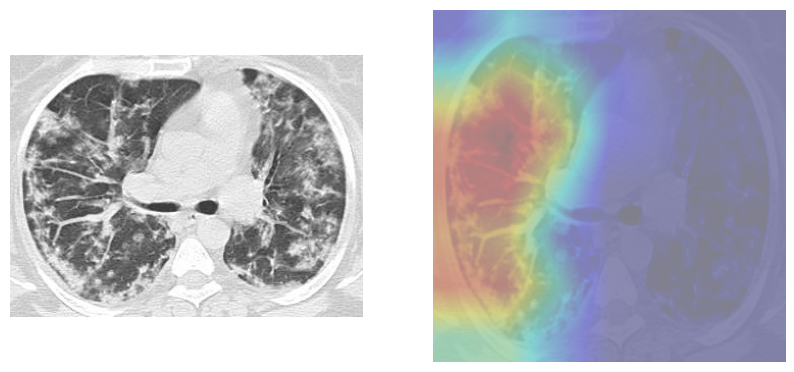

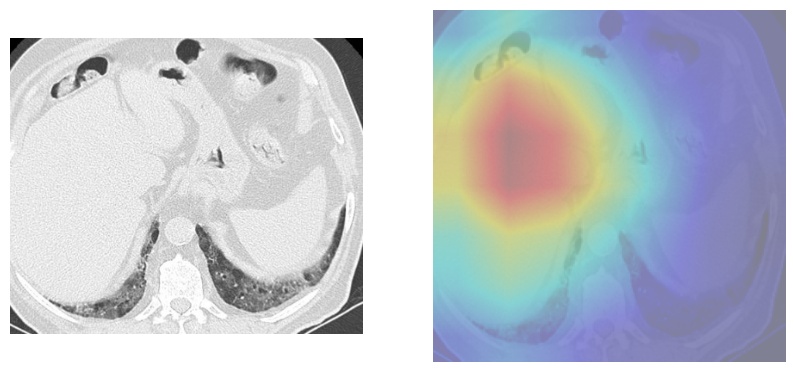

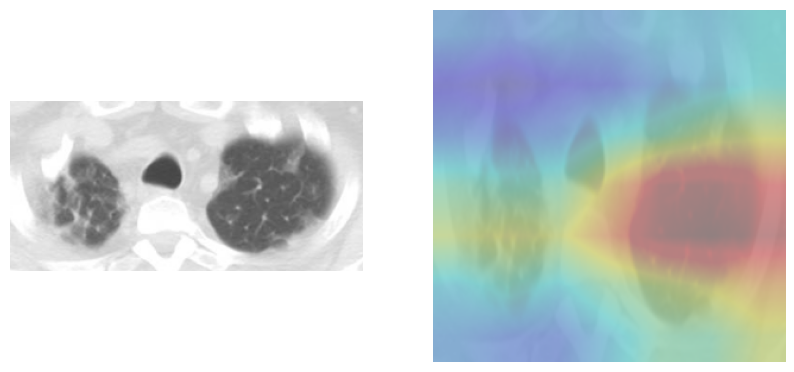

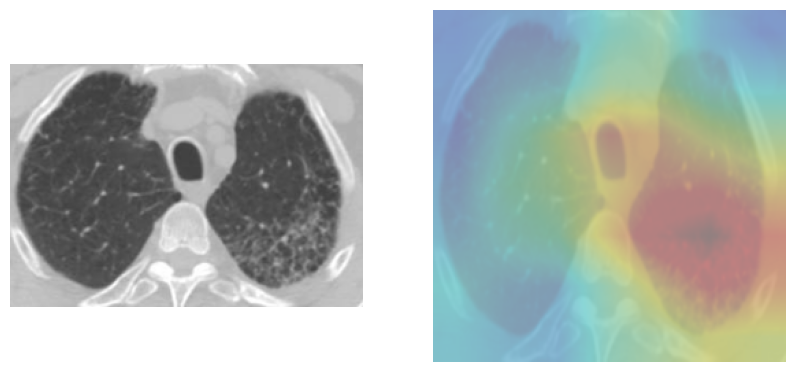

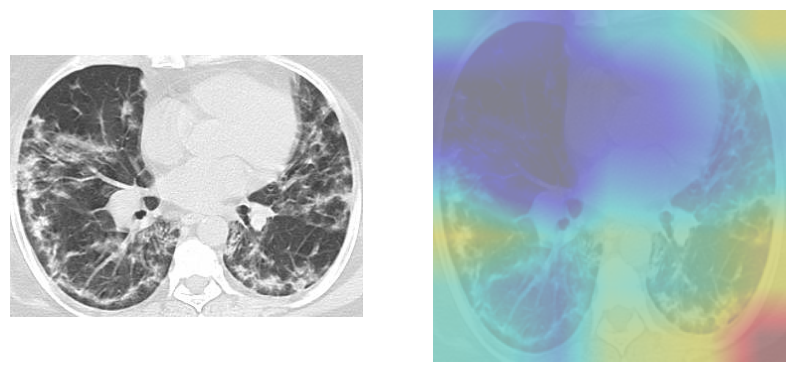

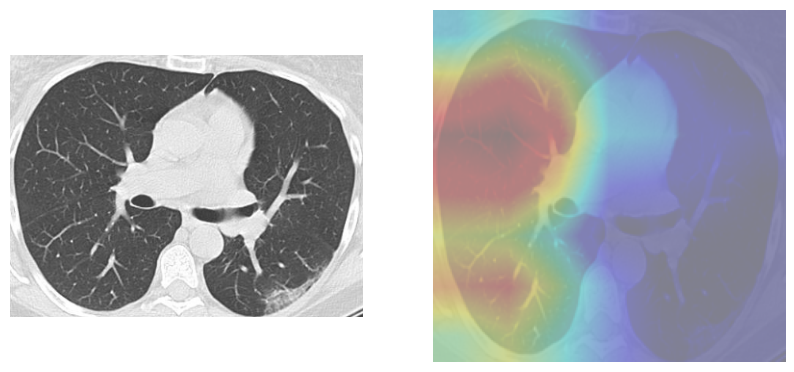

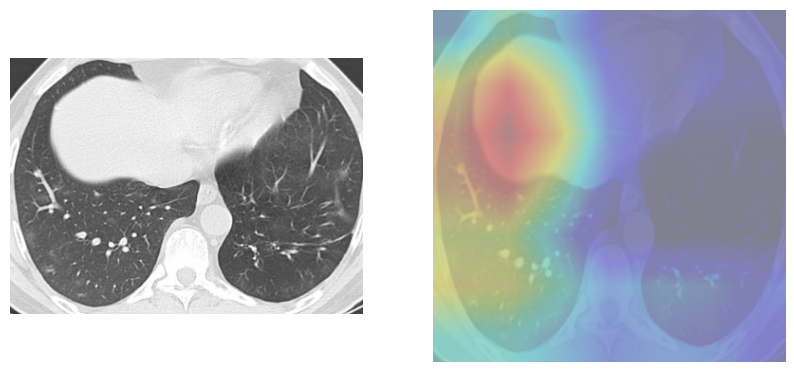

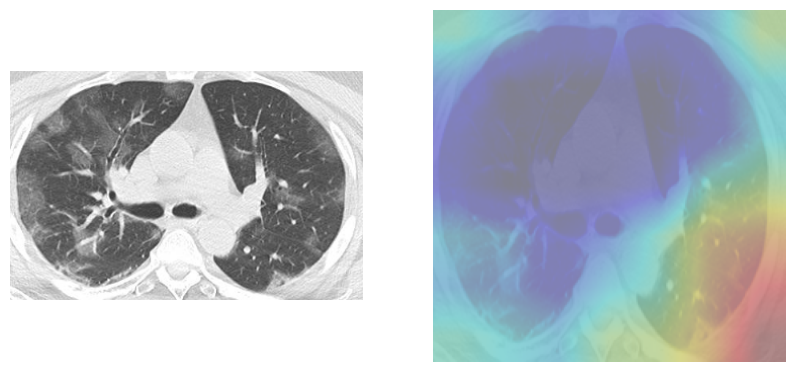

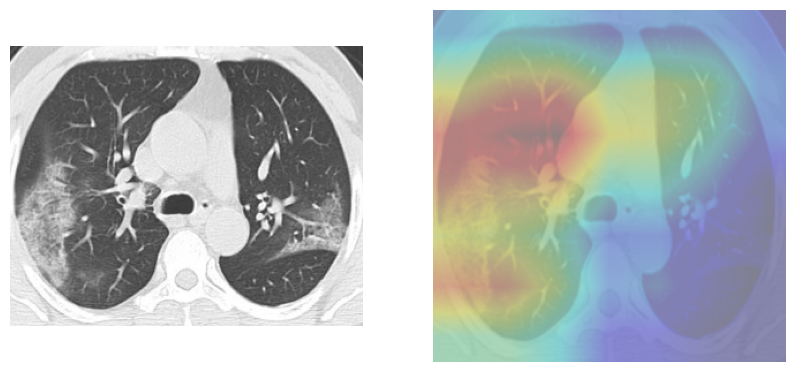

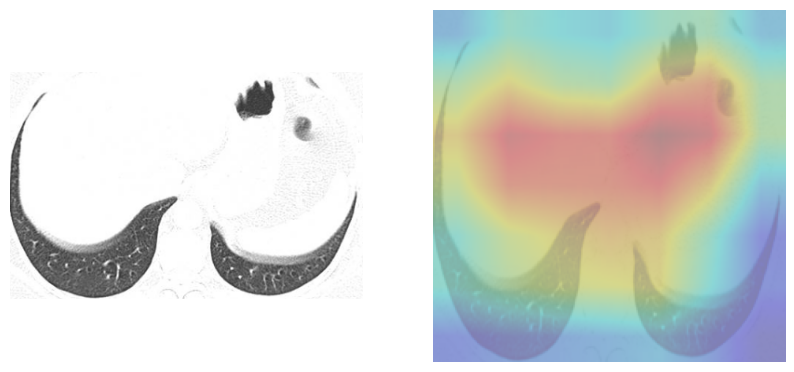

In [152]:
image_files = [f for f in os.listdir('./data/test/covid') if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
selected_images_covid = random.sample(image_files, min(10, len(image_files)))


for i in selected_images_covid:
  plot_GradCam('./data/test/covid/' + i)

Now, envision that we have trained a neural network, obtained heatmaps, and achieved a model performance of 95%. Despite utilizing Grad-CAM, the heatmaps reveal a consistent focus on the corners, evident across numerous images. In your perspective, what could be the underlying problem, and how might we address and overcome this issue?

**Your Answer (10 points)**:

The problem could be:

      • The network is overfitting to the training data and learning spurious features that are not generalizable to new images.

      • The network is underfitting and not learning enough features to capture the complexity of the task.

      • The network architecture or the layer chosen for Grad-CAM is not suitable for the task or the input data.

      • The network is adversarially attacked and manipulated to focus on the wrong regions.

To address and overcome this issue, we could try some of the following solutions:

      • Use data augmentation, regularization, or dropout to reduce overfitting and improve generalization.

      • Use more data, a deeper network, or a different optimizer to increase the network’s capacity and performance.

      • Use a different network architecture or a different layer for Grad-CAM that is more relevant for the task or the input data.

      • Use adversarial training, robust optimization, or defense mechanisms to protect the network from adversarial attacks.